# The Robertson chemical problem

## Mathematical modelling

This problem is often used to test solvers due to its stiffness. The problem describes a reactor in which there is one fast reaction and a slow one. The reactions are given below:

\begin{align*}
      A &\overset{k_1}{\longrightarrow} B\\
      B+B &\overset{k_2}{\longrightarrow} C+B\\
      B+C &\overset{k_3}{\longrightarrow} A+C
\end{align*}


Such reactions can be described by the following equations:
\begin{align*}
    C'_A &= -k_1 C_A + k_3 C_B C_C \\
    C'_B &=  k_1 C_A - k_3 C_B C_C - k_2 C_B^2 \\
    1 &= C_A + C_B + C_C
\end{align*}
with the initial concentrations $C_A(0)=1, C_B(0)=0, C_C(0)=0$. Note that in order to have a DAEs system, we have added the constraint of the mass conservation.


We have chosen the following value for the kinetics constants as follows:

\begin{align*}
    k_1 &= 0.04 \\
    k_2 &= 3e7 \\
    k_3 &= 1e4
\end{align*}

Therefore, the first reaction is slow while the second one is fast.

The corresponding ODEs system is:

\begin{align*}
    C'_A &= -k_1 C_A + k_3 C_B C_C \\
    C'_B &=  k_1 C_A - k_3 C_B C_C - k_2 C_B^2 \\
    C'_C &= k_2 C_B^2
\end{align*}


## Solving those systems with DAEs solvers

In [1]:
# import solvers
from solvers.bdf import BDFModified
from solvers.radau import RadauModified
from solvers.rosenbrock import Rosenbrock
from solvers.sabm import SABM

In [2]:
# import other useful modules
from time import time
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

Declare the constants of our chemical problem

In [3]:
k1 = 0.04
k2 = 3e7
k3 = 1e4
tspan = [0, 4e6] # tspan = [0, 1000] for comparaison
y0 = [1,0,0]

Create the function describing the DAEs systems such that $M \dot{y} = f(t,y)$:

In [4]:
# index 1 DAE system
def robertsdae(t, y):
    return np.array([-k1*y[0] + k3*y[1]*y[2],
                     k1*y[0] - k3*y[1]*y[2] - k2*y[1]**2,
                     y[0] + y[1] + y[2] - 1])

# mass matrix
M = np.eye(3)
M[-1, -1] = 0

# right hand side of the ODE part of our DAE system
def fun(t, y, x):
    return np.array([-k1*y[0] + k3*y[1]*x[0], 
                     k1*y[0] - k3*y[1]*x[0] - k2*y[1]**2])

# constraints
def gun(t, y, x):
    return np.array([y[0] + y[1] + x[0] - 1])



Parameters of the DAEs solvers similar to those scipy solve_ivp:

In [5]:
rtol = 1e-2
atol = rtol*1e-4

kwargsBDF = {
    'fun': robertsdae,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': BDFModified,
    'rtol': rtol,
    'atol': atol
}

kwargsRadau = {
    'fun': robertsdae,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': RadauModified,
    'rtol': rtol,
    'atol': atol
}

kwargsRosenbrock = {
    'fun': robertsdae,
    't_span': tspan,
    'y0': y0,
    'mass': M,
    'method': Rosenbrock,
    'rtol': rtol,
    'atol': atol,
}

kwargsSABM = {
    'fun': fun,
    't_span': [0, 1000],
    'y0': y0,
    'method': SABM,
    'gun': gun,
    'num_diff': 2,
    'order': 2,
    'rtol': rtol,
    'atol': atol,
    'mode': 'Implicit'
}

Solve the DAEs system using the scipy solve_ivp function:

In [6]:
kwargs = kwargsRadau

before = time()
sol = solve_ivp(**kwargs)
print(f'Success: {sol.success}')
print(f'Temps de calcul : {time()-before}')
t = sol.t

C_a = sol.y[0,:]
C_b = sol.y[1,:]
C_c = sol.y[2,:]

Success: True
Temps de calcul : 0.03789663314819336


Solve the ODEs system

In [7]:
def solve_ODE():
    def robertsode(t, y):
        return np.array([-k1*y[0] + k3*y[1]*y[2],
                        k1*y[0] - k3*y[1]*y[2] - k2*y[1]**2,
                        k2 * y[1]**2])

    y0 = np.array([1, 0, 0])
    sol_ODE = solve_ivp(fun=robertsode, t_span=[0, sol.t[-1]], y0=y0, rtol=1e-12,
                        atol=1e-12, method='Radau', t_eval=sol.t)
    return sol_ODE.t, sol_ODE.y[0, :], sol_ODE.y[1, :], sol_ODE.y[2, :]


t_ODE, a_ODE, b_ODE, c_ODE = solve_ODE()

Plot the evolution of the chemical concentrations over time:

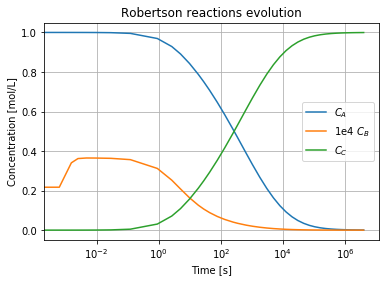

In [8]:
plt.figure()

plt.semilogx(t, C_a, label = r"$C_A$")
plt.semilogx(t, 10000*C_b, label = r"1e4 $C_B$")
plt.semilogx(t, C_c, label = r"$C_C$")
plt.xlabel("Time [s]")
plt.ylabel("Concentration [mol/L]")
plt.title("Robertson reactions evolution")
plt.grid()
plt.legend()
plt.show()

Plot the error of our DAEs solver:

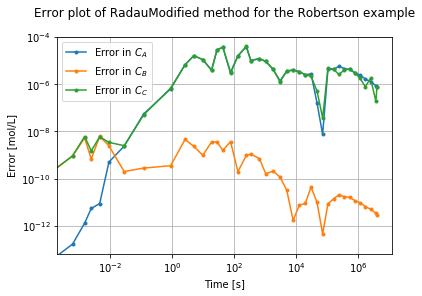

In [9]:
plt.figure()
plt.loglog(t, abs(a_ODE - C_a), ".-", label=r'Error in $C_A$')
plt.loglog(t, abs(b_ODE - C_b), ".-", label=r'Error in $C_B$')
plt.loglog(t, abs(c_ODE - C_c), ".-", label=r'Error in $C_C$')
plt.title(
    f'Error plot of {kwargs["method"].__name__} method for the Robertson example',pad=20)
plt.xlabel('Time [s]')
plt.ylabel('Error [mol/L]')
plt.grid()
plt.legend()
#plt.savefig("robertson_"+kwargs["method"].__name__+".png", dpi=250, bbox_inches="tight")
plt.show()